# VGG

计算机视觉是一直深度学习的主战场，从这里将学习近几年非常流行的卷积网络结构，网络结构由浅变深，参数越来越多，网络有着更多的跨层链接。

VGG是Oxford的Visual Geometry Group的组提出的。该网络是在ILSVRC 2014上的相关工作，主要工作是证明了增加网络的深度能够在一定程度上影响网络最终的性能。VGG有两种结构，分别是VGG16和VGG19，两者并没有本质上的区别，只是网络深度不一样。当这个模型被提出时，由于它的简洁性和实用性，马上成为了当时最流行的卷积神经网络模型。它在图像分类和目标检测任务中都表现出非常好的结果。在2014年的ILSVRC比赛中，VGG 在Top-5中取得了92.3%的正确率。

## CIFAR 10

首先介绍一个数据集 CIFAR10，后续以此数据集为例介绍各种卷积网络的结构。

CIFAR10 这个数据集一共有 50000 张训练集，10000 张测试集，两个数据集里面的图片都是 png 彩色图片，图片大小是 32 x 32 x 3，一共是 10 分类问题，分别为飞机、汽车、鸟、猫、鹿、狗、青蛙、马、船和卡车。这个数据集是对网络性能测试一个非常重要的指标，可以说如果一个网络在这个数据集上超过另外一个网络，那么这个网络性能上一定要比另外一个网络好，目前这个数据集最好的结果是 95% 左右的测试集准确率。

![](images/CIFAR10.png)


CIFAR10 已经被 PyTorch 内置了，使用非常方便，只需要调用 `torchvision.datasets.CIFAR10` 就可以了

## VGGNet
VGGNet 是第一个真正意义上的深层网络结构，其是 ImageNet2014年的冠军，得益于 Python 的函数和循环，我们能够非常方便地构建重复结构的深层网络。

VGG 的网络结构非常简单，就是不断地堆叠卷积层和池化层，下面是网络结构图：

![](images/VGG_network.png)

VGG整个结构只有3×3的卷积层，连续的卷积层后使用池化层隔开。虽然层数很多，但是很简洁。几乎全部使用 3 x 3 的卷积核以及 2 x 2 的池化层，使用小的卷积核进行多层的堆叠和一个大的卷积核的感受野是相同的，同时小的卷积核还能减少参数，同时可以有更深的结构。


VGG网络的特点：
* 小卷积核和连续的卷积层: VGG中使用的都是3×3卷积核，并且使用了连续多个卷积层。这样做的好处主要有，
    - 使用连续的的多个小卷积核(3×3)，来代替一个大的卷积核，例如(5×5)。使用小的卷积核的问题是，其感受野必然变小。所以，VGG中就使用连续的3×3卷积核，来增大感受野。VGG认为2个连续的3×3卷积核能够替代一个5×5卷积核，三个连续的3×3能够代替一个7×7。
    - 小卷积核的参数较少。3个3×3的卷积核参数为3×3×3=27，而一个7×7的卷积核参数为7×7=49
    - 由于每个卷积层都有一个非线性的激活函数，多个卷积层增加了非线性映射。
* 小池化核，使用的是2×2
* 通道数更多，特征度更宽:  每个通道代表着一个FeatureMap，更多的通道数表示更丰富的图像特征。VGG网络第一层的通道数为64，后面每层都进行了翻倍，最多到512个通道，通道数的增加，使得更多的信息可以被提取出来。
* 层数更深:  使用连续的小卷积核代替大的卷积核，网络的深度更深，并且对边缘进行填充，卷积的过程并不会降低图像尺寸。仅使用小的池化单元，降低图像的尺寸。

VGG 的一个关键就是使用很多层 3 x 3 的卷积然后再使用一个最大池化层，这个模块被使用了很多次，下面照着这个结构把网络用PyTorch实现出来。

为了代码的简洁和复用，可以定义一个 VGG 的 block，传入三个参数：
* 第一个是模型层数
* 第二个是输入的通道数
* 第三个是输出的通道数

第一层卷积接受的输入通道就是图片输入的通道数，然后输出最后的输出通道数，后面的卷积接受的通道数就是最后的输出通道数

In [1]:
import torch
from torch import nn
from torch.autograd import Variable

def VGG_Block(num_convs, in_channels, out_channels):
    # 定义第一层
    net = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
           nn.BatchNorm2d(out_channels),
           nn.ReLU(True)] 

    for i in range(num_convs-1): # 定义后面的很多层
        net.append(nn.Conv2d(out_channels, out_channels, 
                             kernel_size=3, padding=1))
        net.append(nn.BatchNorm2d(out_channels))
        net.append(nn.ReLU(True))
        
    net.append(nn.MaxPool2d(2, 2)) # 定义池化层
    return nn.Sequential(*net)

将模型打印出来，可以看到网络的具体结构

In [2]:
block_demo = VGG_Block(3, 64, 128)
print(block_demo)

Sequential(
  (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [3]:
# 首先定义输入为 (1, 64, 300, 300) (batch, channels, imgH, imgW)
input_demo = Variable(torch.zeros(1, 64, 300, 300))
output_demo = block_demo(input_demo)
print(output_demo.shape)

torch.Size([1, 128, 150, 150])


可以看到输出就变为了 `(1, 128, 150, 150)` (batch, channels, imgH, imgW) ，可以看到经过了这一个 VGG block，输入大小被减半，通道数变成了 128

下面我们定义一个函数对这个 VGG block 进行堆叠

In [4]:
def VGG_Stack(num_convs, channels):
    net = []
    for n, c in zip(num_convs, channels):
        in_c = c[0]
        out_c = c[1]
        net.append(VGG_Block(n, in_c, out_c))
    return nn.Sequential(*net)

作为示例，我们定义一个稍微简单一点的 VGG 结构，其中有 8 个卷积层

In [5]:
vgg_net_11 = VGG_Stack((2, 2, 3, 3, 3), 
                    ((3, 64), (64, 128), (128, 256), (256, 512), (512, 512)))
vgg_net = VGG_Stack((2, 2, 2, 3), 
                    ((3, 64), (64, 128), (128, 256), (256, 512)))
print(vgg_net)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  

可以看到网络结构中有个 5 个 最大池化，说明图片的大小会减少 5 倍。可以验证一下，输入一张 32 x 32 的图片看看结果是什么

In [6]:
test_x = Variable(torch.zeros(1, 3, 32, 32))
test_y = vgg_net(test_x)
print(test_y.shape)

torch.Size([1, 512, 2, 2])


可以看到图片减小了 $2^5$ 倍，最后再加上几层全连接，就能够得到我们想要的分类输出

In [7]:
class VGG_Net(nn.Module):
    def __init__(self):
        super(VGG_Net, self).__init__()
        self.feature = VGG_Stack((2, 2, 2, 3), 
                ((3, 64), (64, 128), (128, 256), (256, 512)))
        self.fc = nn.Sequential(
                nn.Linear(2*2*512, 1024),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(1024, 1024),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(1024, 10)
        )
    def forward(self, x):
        x = self.feature(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

然后我们可以训练我们的模型看看在 CIFAR10 上的效果

In [8]:
from torchvision.datasets import CIFAR10
from torchvision import transforms as tfs
from utils import train

# 使用数据变换
def data_tf(x):
    im_aug = tfs.Compose([
        #tfs.Resize(224),
        tfs.ToTensor(),
        tfs.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    x = im_aug(x)
    return x
     
train_set  = CIFAR10('../../data', train=True,  transform=data_tf)
train_data = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_set   = CIFAR10('../../data', train=False, transform=data_tf)
test_data  = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

net = VGG_Net()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [9]:
res = train(net, train_data, test_data, 20, optimizer, criterion)

[ 0] Train:(L=1.689224, Acc=0.340493), Valid:(L=1.514729, Acc=0.449664), T: 00:00:27
[ 1] Train:(L=1.211734, Acc=0.572111), Valid:(L=1.043950, Acc=0.638944), T: 00:00:27
[ 2] Train:(L=0.939749, Acc=0.680647), Valid:(L=0.795742, Acc=0.731408), T: 00:00:27
[ 3] Train:(L=0.776414, Acc=0.742987), Valid:(L=0.773068, Acc=0.741792), T: 00:00:27
[ 4] Train:(L=0.655303, Acc=0.784607), Valid:(L=0.697191, Acc=0.759296), T: 00:00:27
[ 5] Train:(L=0.565006, Acc=0.816956), Valid:(L=0.634936, Acc=0.791436), T: 00:00:27
[ 6] Train:(L=0.487787, Acc=0.842172), Valid:(L=0.643098, Acc=0.788766), T: 00:00:27
[ 7] Train:(L=0.422939, Acc=0.866129), Valid:(L=0.539120, Acc=0.828323), T: 00:00:27
[ 8] Train:(L=0.365580, Acc=0.882413), Valid:(L=0.598219, Acc=0.808248), T: 00:00:27
[ 9] Train:(L=0.316299, Acc=0.899097), Valid:(L=0.601980, Acc=0.821005), T: 00:00:27
[10] Train:(L=0.271955, Acc=0.914043), Valid:(L=0.664353, Acc=0.803402), T: 00:00:27
[11] Train:(L=0.240455, Acc=0.923633), Valid:(L=0.555360, Acc=0.8

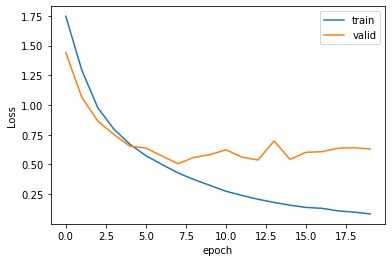

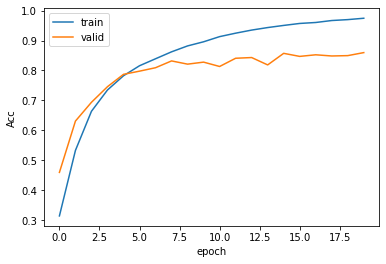

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(res[0], label='train')
plt.plot(res[2], label='valid')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.savefig('fig-res-vgg-train-validate-loss.pdf')
plt.show()

plt.plot(res[1], label='train')
plt.plot(res[3], label='valid')
plt.xlabel('epoch')
plt.ylabel('Acc')
plt.legend(loc='best')
plt.savefig('fig-res-vgg-train-validate-acc.pdf')
plt.show()

In [17]:
# save raw data
import numpy
numpy.save('fig-res-vgg_data.npy', res)

可以看到，跑完 20 次，VGG 能在 CIFAR10 上取得 86% 左右的测试准确率

## 参考

* [一文读懂VGG网络](https://zhuanlan.zhihu.com/p/41423739)